In [1]:
import os
import pickle

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
def load_config(result_dir):
    config_file = os.path.join(result_dir, 'config.pkl')
    with open(config_file, 'rb') as f:
        return pickle.load(f)

def load_result(result_dir):
    history_file = os.path.join(result_dir, 'history.csv')
    return pd.read_csv(history_file)

def compute_mean_time(r):
    return r[r.epoch>0].time.mean()

def get_num_samples(config):
    dc = config['data']
    return dc['n_train'] + dc['n_valid']

In [4]:
ls $SCRATCH/cosmoflow-benchmark/

cosmoflow-154846/         cosmoflow-dummy-n16/    scaling-project-n4/
cosmoflow-154858/         cosmoflow-dummy-n2/     scaling-project-n64/
cosmoflow-154996/         cosmoflow-dummy-n32/    scaling-project-n8/
cosmoflow-155912/         cosmoflow-dummy-n4/     scaling-scratch-n1/
cosmoflow-155987/         cosmoflow-dummy-n64/    scaling-scratch-n16/
cosmoflow-156746/         cosmoflow-dummy-n8/     scaling-scratch-n2/
cosmoflow-157761/         cosmoflow-hvd/          scaling-scratch-n32/
cosmoflow-158072/         cosmoflow-scaling-n1/   scaling-scratch-n4/
cosmoflow-158127/         cosmoflow-scaling-n16/  scaling-scratch-n64/
cosmoflow-158130/         cosmoflow-scaling-n2/   scaling-scratch-n8/
cosmoflow-158215/         cosmoflow-scaling-n4/   wscaling-dwarp-n1/
cosmoflow-158230/         cosmoflow-scaling-n8/   wscaling-dwarp-n16/
cosmoflow-158235/         cosmoflow-test/         wscaling-dwarp-n2/
cosmoflow-158333/         data/                   wscaling-dwarp-n32/
cosmoflow-19-06-11

In [5]:
ranks = np.array([1, 2, 4, 8, 16, 32, 64])
results_pattern = os.path.expandvars('$SCRATCH/cosmoflow-benchmark/scaling-dummy-n%i')

configs, results = [], []
for r in ranks:
    result_dir = results_pattern % r
    configs.append(load_config(result_dir))
    results.append(load_result(result_dir).assign(ranks=r))

samples = np.array([get_num_samples(c)*r for (c,r) in zip(configs, ranks)])
times = np.array([compute_mean_time(r) for r in results])
throughputs = samples / times

scaling_dummy = pd.DataFrame(dict(ranks=ranks, samples=samples, 
                                  times=times, throughputs=throughputs))

In [6]:
ranks = np.array([1, 2, 4, 8, 16, 32, 64])
results_pattern = os.path.expandvars('$SCRATCH/cosmoflow-benchmark/wscaling-scratch-n%i')

configs, results = [], []
for r in ranks:
    result_dir = results_pattern % r
    configs.append(load_config(result_dir))
    results.append(load_result(result_dir).assign(ranks=r))

samples = np.array([get_num_samples(c) for (c,r) in zip(configs, ranks)])
times = np.array([compute_mean_time(r) for r in results])
throughputs = samples / times

scaling_scratch = pd.DataFrame(dict(ranks=ranks, samples=samples, 
                                    times=times, throughputs=throughputs))

In [7]:
ranks = np.array([1, 2, 4, 8, 16, 32, 64])
results_pattern = os.path.expandvars('$SCRATCH/cosmoflow-benchmark/wscaling-dwarp-n%i')

configs, results = [], []
for r in ranks:
    result_dir = results_pattern % r
    configs.append(load_config(result_dir))
    results.append(load_result(result_dir).assign(ranks=r))

samples = np.array([get_num_samples(c) for (c,r) in zip(configs, ranks)])
times = np.array([compute_mean_time(r) for r in results])
throughputs = samples / times

scaling_dwarp = pd.DataFrame(dict(ranks=ranks, samples=samples, 
                                  times=times, throughputs=throughputs))

In [8]:
plt.rcParams.update({'font.size': 14})

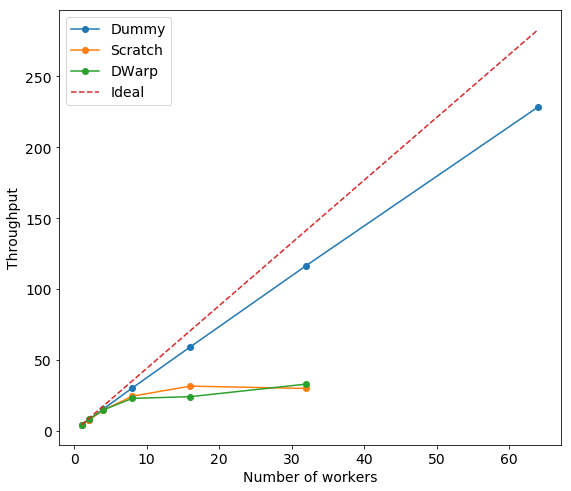

In [9]:
plt.figure(figsize=(9,8))
plt.plot(scaling_dummy['ranks'], scaling_dummy['throughputs'], 'o-', label='Dummy')
plt.plot(scaling_scratch['ranks'], scaling_scratch['throughputs'], 'o-', label='Scratch')
plt.plot(scaling_dwarp['ranks'], scaling_dwarp['throughputs'], 'o-', label='DWarp')
plt.xlabel('Number of workers')
plt.ylabel('Throughput')

plt.plot(ranks, ranks*throughputs[0], '--', label='Ideal')
plt.legend(loc=0);

## Discussion

The scaling performance is currently *very* poor with real data on the SCRATCH file system. With dummy data the scaling is very good. I'll need to investigate further.